# Latent Class Model for Multivariate Categorical Data

Implementation of the latent class model with EM algorithm as described in the notes.

## Model

Let $X = (X^{(1)}, \ldots, X^{(m)})$ be a vector of categorical variables, where $X^{(r)} \in \{1, 2, \ldots, C_r\}$.

We introduce a latent class variable $H \in \{1, \ldots, K\}$ and assume conditional independence:

$$P(X = x) = \sum_{k=1}^K P(H = k) \prod_{r=1}^m P(X^{(r)} = x^{(r)} | H = k)$$

## Parameters

- Mixture weights: $\pi_k = P(H = k)$
- Component probabilities: $\theta_{rkc} = P(X^{(r)} = c | H = k)$
## Identifiability

To resolve label switching and identifiability issues, we impose the constraint:

$$\pi_1 \geq \pi_2 \geq \cdots \geq \pi_K$$

After fitting the model, latent classes are automatically sorted by their mixture weights in descending order.

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, Dict, Optional
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Plotting configuration
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

## 1. Data Generation

Generate synthetic data from a true latent class model.

In [2]:
class LatentClassDataGenerator:
    """Generate synthetic data from a latent class model."""
    
    def __init__(self, m: int, K: int, C_r: int, seed: Optional[int] = None):
        """
        Parameters:
        -----------
        m : int
            Number of categorical variables
        K : int
            Number of latent classes
        C_r : int
            Number of categories for each variable (assumed same for all)
        seed : int, optional
            Random seed
        """
        if seed is not None:
            np.random.seed(seed)
        
        self.m = m
        self.K = K
        self.C_r = C_r
        
        # Generate true parameters
        self.true_pi = self._generate_mixture_weights()
        self.true_theta = self._generate_component_probs()
        
        # Sort classes by mixture weights (pi_1 >= pi_2 >= ... >= pi_K)
        self._sort_classes()
    
    def _generate_mixture_weights(self) -> np.ndarray:
        """Generate mixture weights that sum to 1."""
        pi = np.random.dirichlet(np.ones(self.K))
        return pi
    
    def _generate_component_probs(self) -> np.ndarray:
        """Generate component categorical probabilities.
        
        Returns:
        --------
        theta : np.ndarray of shape (K, m, C_r)
            theta[k, r, c] = P(X^(r) = c | H = k)
        """
        theta = np.zeros((self.K, self.m, self.C_r))
        
        for k in range(self.K):
            for r in range(self.m):
                # Sample from Dirichlet to ensure probabilities sum to 1
                theta[k, r, :] = np.random.dirichlet(np.ones(self.C_r))
        
        return theta
    
    def _sort_classes(self):
        """Sort latent classes by mixture weights in descending order."""
        sort_idx = np.argsort(self.true_pi)[::-1]
        self.true_pi = self.true_pi[sort_idx]
        self.true_theta = self.true_theta[sort_idx, :, :]
    
    def generate_data(self, n: int) -> Tuple[np.ndarray, np.ndarray]:
        """Generate n samples from the latent class model.
        
        Parameters:
        -----------
        n : int
            Number of samples to generate
        
        Returns:
        --------
        X : np.ndarray of shape (n, m)
            Observed categorical data (values in {0, 1, ..., C_r-1})
        H : np.ndarray of shape (n,)
            True latent class assignments (values in {0, 1, ..., K-1})
        """
        # Sample latent classes
        H = np.random.choice(self.K, size=n, p=self.true_pi)
        
        # Sample observations given latent classes
        X = np.zeros((n, self.m), dtype=int)
        
        for i in range(n):
            k = H[i]
            for r in range(self.m):
                # Sample X^(r) from categorical distribution given H=k
                X[i, r] = np.random.choice(self.C_r, p=self.true_theta[k, r, :])
        
        return X, H
    
    def get_true_parameters(self) -> Dict[str, np.ndarray]:
        """Return true parameters for comparison."""
        return {
            'pi': self.true_pi.copy(),
            'theta': self.true_theta.copy()
        }

## 2. EM Algorithm Implementation

Implement the EM algorithm with numerically stable log-space calculations.

In [3]:
class LatentClassEM:
    """EM algorithm for latent class model estimation."""
    
    def __init__(self, m: int, K: int, C_r: int, seed: Optional[int] = None):
        """
        Parameters:
        -----------
        m : int
            Number of categorical variables
        K : int
            Number of latent classes
        C_r : int
            Number of categories for each variable
        seed : int, optional
            Random seed for initialization
        """
        self.m = m
        self.K = K
        self.C_r = C_r
        self.seed = seed
        
        # Parameters to be estimated
        self.pi = None  # Shape: (K,)
        self.theta = None  # Shape: (K, m, C_r)
        
        # Training history
        self.log_likelihoods = []
        self.n_iterations = 0
    
    def _initialize_parameters(self):
        """Randomly initialize parameters."""
        if self.seed is not None:
            np.random.seed(self.seed)
        
        # Initialize mixture weights
        self.pi = np.random.dirichlet(np.ones(self.K))
        
        # Initialize component probabilities
        self.theta = np.zeros((self.K, self.m, self.C_r))
        for k in range(self.K):
            for r in range(self.m):
                self.theta[k, r, :] = np.random.dirichlet(np.ones(self.C_r))
    
    def _compute_log_likelihood(self, X: np.ndarray) -> float:
        """Compute log-likelihood of the data.
        
        Parameters:
        -----------
        X : np.ndarray of shape (n, m)
            Observed data
        
        Returns:
        --------
        log_lik : float
            Log-likelihood value
        """
        n = X.shape[0]
        log_lik = 0.0
        
        # Vectorized computation
        # For each sample i and class k, compute log P(X_i | H=k)
        log_class_probs = np.zeros((n, self.K))
        
        for k in range(self.K):
            # log P(H=k)
            log_class_probs[:, k] = np.log(self.pi[k])
            
            # Add log P(X^(r) | H=k) for each r
            for r in range(self.m):
                # Extract the probabilities for observed categories
                log_class_probs[:, k] += np.log(self.theta[k, r, X[:, r]])
        
        # Use log-sum-exp trick for numerical stability
        max_log_prob = np.max(log_class_probs, axis=1, keepdims=True)
        log_lik = np.sum(max_log_prob + np.log(np.sum(np.exp(log_class_probs - max_log_prob), axis=1, keepdims=True)))
        
        return log_lik
    
    def _e_step(self, X: np.ndarray) -> np.ndarray:
        """E-step: Compute posterior probabilities gamma_ik.
        
        Parameters:
        -----------
        X : np.ndarray of shape (n, m)
            Observed data
        
        Returns:
        --------
        gamma : np.ndarray of shape (n, K)
            Posterior probabilities gamma[i, k] = P(H_i = k | X_i)
        """
        n = X.shape[0]
        
        # Compute a_ik = log pi_k + sum_r log theta_{rk,X_i^(r)}
        a = np.zeros((n, self.K))
        
        for k in range(self.K):
            a[:, k] = np.log(self.pi[k])
            for r in range(self.m):
                a[:, k] += np.log(self.theta[k, r, X[:, r]])
        
        # Numerically stable computation of gamma using log-space
        # gamma_ik = exp(a_ik - M_i) / sum_j exp(a_ij - M_i)
        M = np.max(a, axis=1, keepdims=True)
        exp_a = np.exp(a - M)
        gamma = exp_a / np.sum(exp_a, axis=1, keepdims=True)
        
        return gamma
    
    def _m_step(self, X: np.ndarray, gamma: np.ndarray):
        """M-step: Update parameters.
        
        Parameters:
        -----------
        X : np.ndarray of shape (n, m)
            Observed data
        gamma : np.ndarray of shape (n, K)
            Posterior probabilities from E-step
        """
        n = X.shape[0]
        
        # Update mixture weights: pi_k = (1/n) * sum_i gamma_ik
        self.pi = np.mean(gamma, axis=0)
        
        # Update component probabilities: theta_{rkc} = sum_i gamma_ik * 1(X_i^(r) = c) / sum_i gamma_ik
        for k in range(self.K):
            for r in range(self.m):
                for c in range(self.C_r):
                    # Vectorized computation
                    mask = (X[:, r] == c).astype(float)
                    self.theta[k, r, c] = np.sum(gamma[:, k] * mask) / np.sum(gamma[:, k])
        
        # Ensure numerical stability (avoid zeros)
        self.theta = np.maximum(self.theta, 1e-10)
        # Renormalize to ensure probabilities sum to 1
        self.theta = self.theta / np.sum(self.theta, axis=2, keepdims=True)
    
    def fit(self, X: np.ndarray, max_iter: int = 100, tol: float = 1e-6, verbose: bool = True) -> Dict:
        """Fit the latent class model using EM algorithm.
        
        Parameters:
        -----------
        X : np.ndarray of shape (n, m)
            Observed data
        max_iter : int
            Maximum number of iterations
        tol : float
            Convergence tolerance for log-likelihood change
        verbose : bool
            Whether to print progress
        
        Returns:
        --------
        history : dict
            Training history including log-likelihoods
        """
        # Initialize parameters
        self._initialize_parameters()
        
        # Initialize history
        self.log_likelihoods = []
        
        if verbose:
            print("Starting EM algorithm...")
            print(f"Data: n={X.shape[0]}, m={self.m}, K={self.K}, C_r={self.C_r}")
        
        for iteration in range(max_iter):
            # E-step
            gamma = self._e_step(X)
            
            # M-step
            self._m_step(X, gamma)
            
            # Compute log-likelihood
            log_lik = self._compute_log_likelihood(X)
            self.log_likelihoods.append(log_lik)
            
            if verbose and (iteration + 1) % 10 == 0:
                print(f"Iteration {iteration + 1}/{max_iter}, Log-likelihood: {log_lik:.4f}")
            
            # Check convergence
            if iteration > 0:
                log_lik_change = abs(self.log_likelihoods[-1] - self.log_likelihoods[-2])
                if log_lik_change < tol:
                    if verbose:
                        print(f"\nConverged at iteration {iteration + 1}")
                        print(f"Log-likelihood change: {log_lik_change:.6e} < {tol}")
                    self.n_iterations = iteration + 1
                    break
        else:
            if verbose:
                print(f"\nReached maximum iterations: {max_iter}")
            self.n_iterations = max_iter
        
        
        # Sort classes by mixture weights (resolve identifiability)
        self._sort_classes()
        if verbose:
            print(f"Final log-likelihood: {self.log_likelihoods[-1]:.4f}")
        
        return {
            'log_likelihoods': self.log_likelihoods,
            'n_iterations': self.n_iterations,
            'final_log_lik': self.log_likelihoods[-1]
        }
    
    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        """Predict posterior class probabilities for new data.
        
        Parameters:
        -----------
        X : np.ndarray of shape (n, m)
            Observed data
        
        Returns:
        --------
        gamma : np.ndarray of shape (n, K)
            Posterior class probabilities
        """
        return self._e_step(X)
    
    def predict(self, X: np.ndarray) -> np.ndarray:
        """Predict class assignments for new data.
        
        Parameters:
        -----------
        X : np.ndarray of shape (n, m)
            Observed data
        
        Returns:
        --------
        H_pred : np.ndarray of shape (n,)
            Predicted class assignments
        """
        gamma = self.predict_proba(X)
        return np.argmax(gamma, axis=1)
    
    def _sort_classes(self):
        """Sort latent classes by mixture weights in descending order.
        
        This resolves identifiability issues by imposing the constraint:
        pi_1 >= pi_2 >= ... >= pi_K
        """
        # Get sorting indices (descending order)
        sort_idx = np.argsort(self.pi)[::-1]
        
        # Reorder mixture weights
        self.pi = self.pi[sort_idx]
        
        # Reorder component probabilities
        self.theta = self.theta[sort_idx, :, :]
    
    def get_parameters(self) -> Dict[str, np.ndarray]:
        """Return estimated parameters."""
        return {
            'pi': self.pi.copy(),
            'theta': self.theta.copy()
        }

## 3. Visualization Functions

In [4]:
def plot_convergence(log_likelihoods: list, title: str = "EM Algorithm Convergence"):
    """Plot log-likelihood convergence."""
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(log_likelihoods) + 1), log_likelihoods, 'b-', linewidth=2)
    plt.xlabel('Iteration', fontsize=12)
    plt.ylabel('Log-Likelihood', fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_parameter_comparison(true_params: Dict, estimated_params: Dict, param_name: str = 'pi'):
    """Compare true and estimated parameters."""
    if param_name == 'pi':
        true_pi = true_params['pi']
        est_pi = estimated_params['pi']
        K = len(true_pi)
        
        plt.figure(figsize=(10, 6))
        x = np.arange(K)
        width = 0.35
        
        plt.bar(x - width/2, true_pi, width, label='True', alpha=0.8)
        plt.bar(x + width/2, est_pi, width, label='Estimated', alpha=0.8)
        
        plt.xlabel('Class k', fontsize=12)
        plt.ylabel('Mixture Weight π_k', fontsize=12)
        plt.title('Comparison of Mixture Weights', fontsize=14, fontweight='bold')
        plt.xticks(x, [f'Class {k}' for k in range(K)])
        plt.legend(fontsize=11)
        plt.grid(True, alpha=0.3, axis='y')
        plt.tight_layout()
        plt.show()
        
        # Print numerical comparison
        print("\nMixture Weights Comparison:")
        print(f"{'Class':<10} {'True':<15} {'Estimated':<15} {'Absolute Error':<15}")
        print("-" * 60)
        for k in range(K):
            error = abs(true_pi[k] - est_pi[k])
            print(f"{k:<10} {true_pi[k]:<15.4f} {est_pi[k]:<15.4f} {error:<15.4f}")
        print(f"\nMean Absolute Error: {np.mean(np.abs(true_pi - est_pi)):.6f}")


def plot_theta_comparison(true_params: Dict, estimated_params: Dict, k: int = 0, r: int = 0):
    """Compare true and estimated theta for a specific class k and variable r."""
    true_theta = true_params['theta'][k, r, :]
    est_theta = estimated_params['theta'][k, r, :]
    C_r = len(true_theta)
    
    plt.figure(figsize=(10, 6))
    x = np.arange(C_r)
    width = 0.35
    
    plt.bar(x - width/2, true_theta, width, label='True', alpha=0.8)
    plt.bar(x + width/2, est_theta, width, label='Estimated', alpha=0.8)
    
    plt.xlabel('Category c', fontsize=12)
    plt.ylabel(f'θ_{{{r}{k}c}}', fontsize=12)
    plt.title(f'Comparison of Component Probabilities (Class k={k}, Variable r={r})', 
              fontsize=14, fontweight='bold')
    plt.xticks(x, [f'Cat {c}' for c in range(C_r)])
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()


def plot_theta_heatmap(params: Dict, title: str = "Component Probabilities θ"):
    """Plot heatmap of theta parameters.
    
    For each class k, shows m x C_r heatmap of probabilities.
    """
    theta = params['theta']  # Shape: (K, m, C_r)
    K, m, C_r = theta.shape
    
    fig, axes = plt.subplots(1, K, figsize=(5*K, 6))
    if K == 1:
        axes = [axes]
    
    for k in range(K):
        sns.heatmap(theta[k, :, :], annot=True, fmt='.3f', cmap='YlOrRd', 
                    cbar=True, ax=axes[k], vmin=0, vmax=1)
        axes[k].set_xlabel('Category c', fontsize=11)
        axes[k].set_ylabel('Variable r', fontsize=11)
        axes[k].set_title(f'Class k={k}', fontsize=12, fontweight='bold')
    
    fig.suptitle(title, fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()


def plot_class_assignments(true_classes: np.ndarray, predicted_classes: np.ndarray):
    """Visualize true vs predicted class assignments."""
    # Confusion matrix
    K = len(np.unique(true_classes))
    confusion = np.zeros((K, K))
    
    for true_k in range(K):
        for pred_k in range(K):
            confusion[true_k, pred_k] = np.sum((true_classes == true_k) & (predicted_classes == pred_k))
    
    plt.figure(figsize=(8, 7))
    sns.heatmap(confusion, annot=True, fmt='.0f', cmap='Blues', cbar=True)
    plt.xlabel('Predicted Class', fontsize=12)
    plt.ylabel('True Class', fontsize=12)
    plt.title('Confusion Matrix: True vs Predicted Class Assignments', 
              fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Calculate accuracy (accounting for label permutation)
    from scipy.optimize import linear_sum_assignment
    row_ind, col_ind = linear_sum_assignment(-confusion)
    accuracy = confusion[row_ind, col_ind].sum() / len(true_classes)
    
    print(f"\nClassification Accuracy (best label matching): {accuracy:.4f}")
    print(f"Optimal label mapping: {dict(zip(row_ind, col_ind))}")

## 4. Main Experiment

Run the complete experiment with data generation, model fitting, and visualization.

In [5]:
# ============================================================
# PARAMETERS - Easily adjustable
# ============================================================

# Data parameters
m = 50          # Number of categorical variables
K = 4           # Number of latent classes
C_r = 3         # Number of categories per variable
n = 2000        # Number of samples

# EM parameters
max_iter = 200  # Maximum EM iterations
tol = 1e-6      # Convergence tolerance

# Random seeds
data_seed = 42
em_seed = 123

print("="*60)
print("LATENT CLASS MODEL EXPERIMENT")
print("="*60)
print(f"\nData Parameters:")
print(f"  - Number of variables (m): {m}")
print(f"  - Number of latent classes (K): {K}")
print(f"  - Categories per variable (C_r): {C_r}")
print(f"  - Number of samples (n): {n}")
print(f"\nEM Parameters:")
print(f"  - Maximum iterations: {max_iter}")
print(f"  - Convergence tolerance: {tol}")
print("="*60)

LATENT CLASS MODEL EXPERIMENT

Data Parameters:
  - Number of variables (m): 50
  - Number of latent classes (K): 4
  - Categories per variable (C_r): 3
  - Number of samples (n): 2000

EM Parameters:
  - Maximum iterations: 200
  - Convergence tolerance: 1e-06


In [6]:
# ============================================================
# STEP 1: Generate Synthetic Data
# ============================================================

print("\n[STEP 1] Generating synthetic data...")

generator = LatentClassDataGenerator(m=m, K=K, C_r=C_r, seed=data_seed)
X, H_true = generator.generate_data(n=n)
true_params = generator.get_true_parameters()

print(f"✓ Generated {n} samples")
print(f"  Data shape: {X.shape}")
print(f"  True class distribution: {np.bincount(H_true)}")


[STEP 1] Generating synthetic data...
✓ Generated 2000 samples
  Data shape: (2000, 50)
  True class distribution: [1050  468  325  157]


In [7]:
# ============================================================
# STEP 2: Fit Latent Class Model using EM
# ============================================================

print("\n[STEP 2] Fitting latent class model...\n")

model = LatentClassEM(m=m, K=K, C_r=C_r, seed=em_seed)
history = model.fit(X, max_iter=max_iter, tol=tol, verbose=True)

estimated_params = model.get_parameters()

print("\n✓ Model fitting complete!")


[STEP 2] Fitting latent class model...

Starting EM algorithm...
Data: n=2000, m=50, K=4, C_r=3

Converged at iteration 5
Log-likelihood change: 9.761279e-07 < 1e-06
Final log-likelihood: -84720.6294

✓ Model fitting complete!


In [8]:
# ============================================================
# STEP 3: Make Predictions
# ============================================================

print("\n[STEP 3] Making predictions...")

H_pred = model.predict(X)
gamma_pred = model.predict_proba(X)

print(f"✓ Predictions complete")
print(f"  Predicted class distribution: {np.bincount(H_pred)}")


[STEP 3] Making predictions...
✓ Predictions complete
  Predicted class distribution: [1050  468  325  157]


## 5. Visualizations and Analysis


[VISUALIZATION] Plotting convergence...



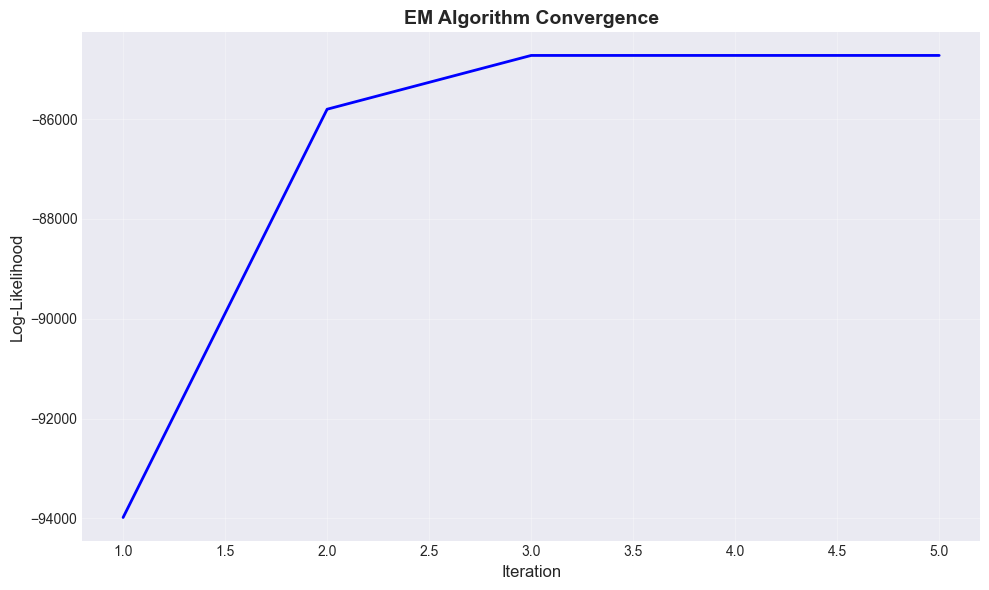

In [9]:
# ============================================================
# VISUALIZATION 1: Convergence Plot
# ============================================================

print("\n[VISUALIZATION] Plotting convergence...\n")
plot_convergence(history['log_likelihoods'])


[VISUALIZATION] Comparing mixture weights...



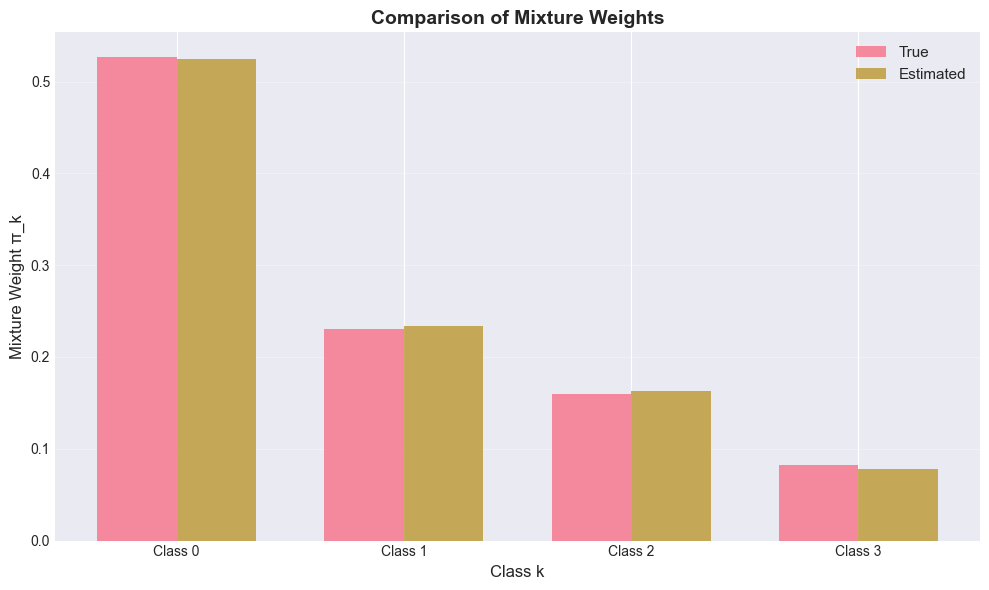


Mixture Weights Comparison:
Class      True            Estimated       Absolute Error 
------------------------------------------------------------
0          0.5273          0.5250          0.0022         
1          0.2306          0.2340          0.0034         
2          0.1599          0.1625          0.0026         
3          0.0822          0.0785          0.0037         

Mean Absolute Error: 0.002974


In [10]:
# ============================================================
# VISUALIZATION 2: Mixture Weights Comparison
# ============================================================

print("\n[VISUALIZATION] Comparing mixture weights...\n")
plot_parameter_comparison(true_params, estimated_params, param_name='pi')


[VISUALIZATION] Comparing component probabilities (sample)...



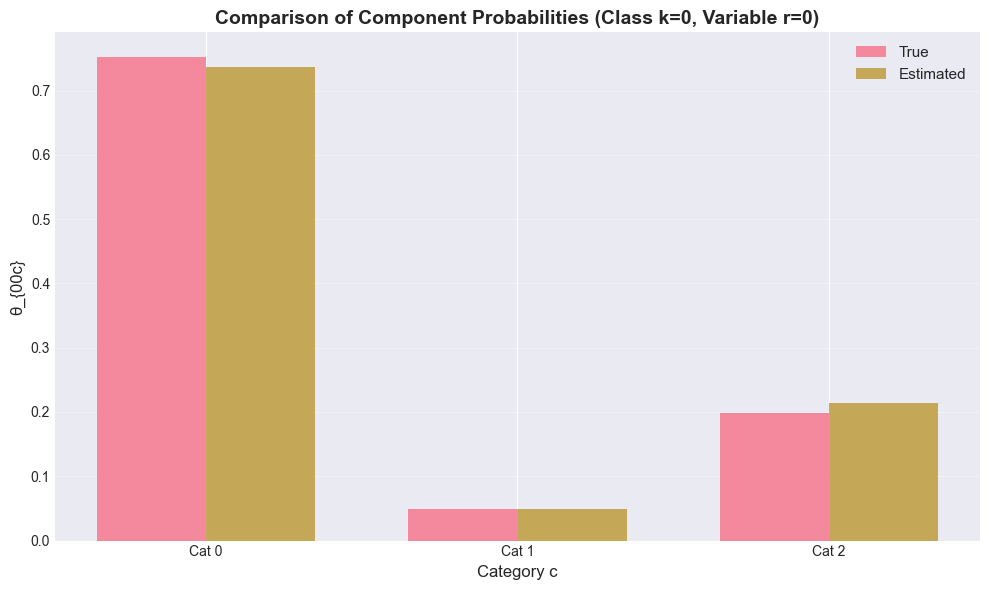

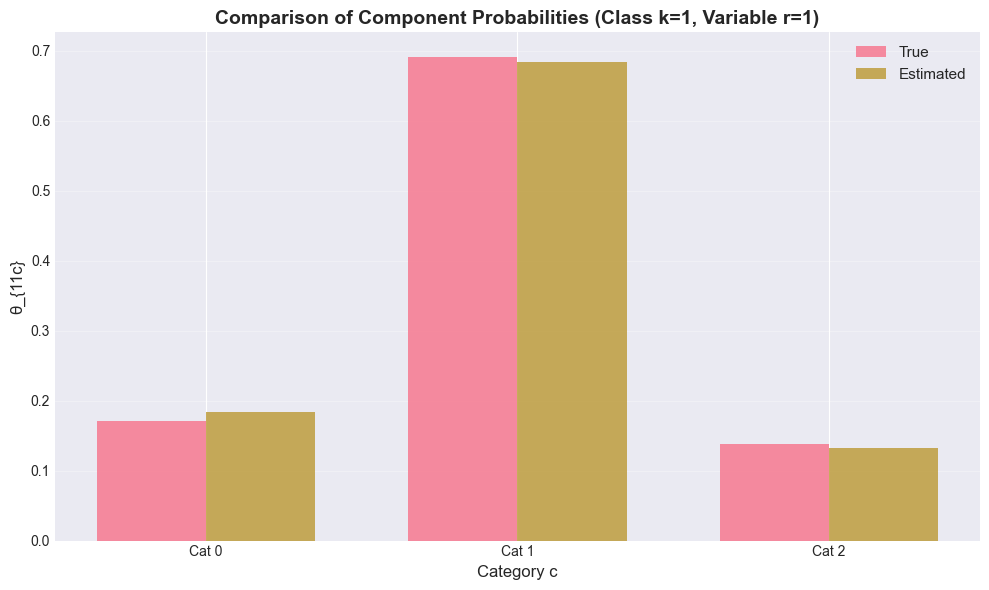

In [11]:
# ============================================================
# VISUALIZATION 3: Component Probabilities - Sample Comparison
# ============================================================

print("\n[VISUALIZATION] Comparing component probabilities (sample)...\n")

# Show comparison for class 0, variable 0
plot_theta_comparison(true_params, estimated_params, k=0, r=0)

# Show comparison for another example
if K > 1 and m > 1:
    plot_theta_comparison(true_params, estimated_params, k=1, r=1)


[VISUALIZATION] Plotting theta heatmaps...



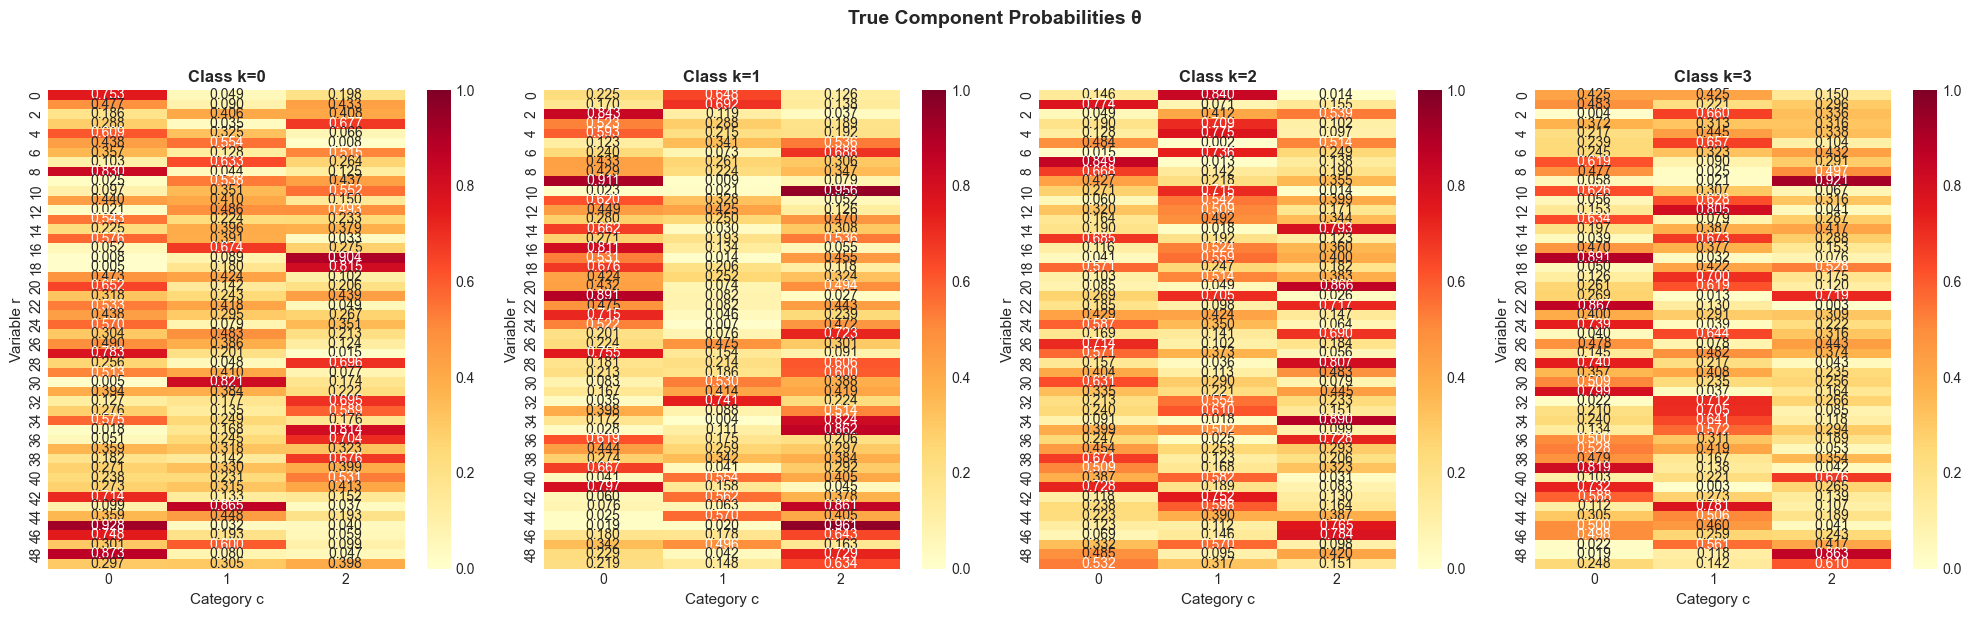

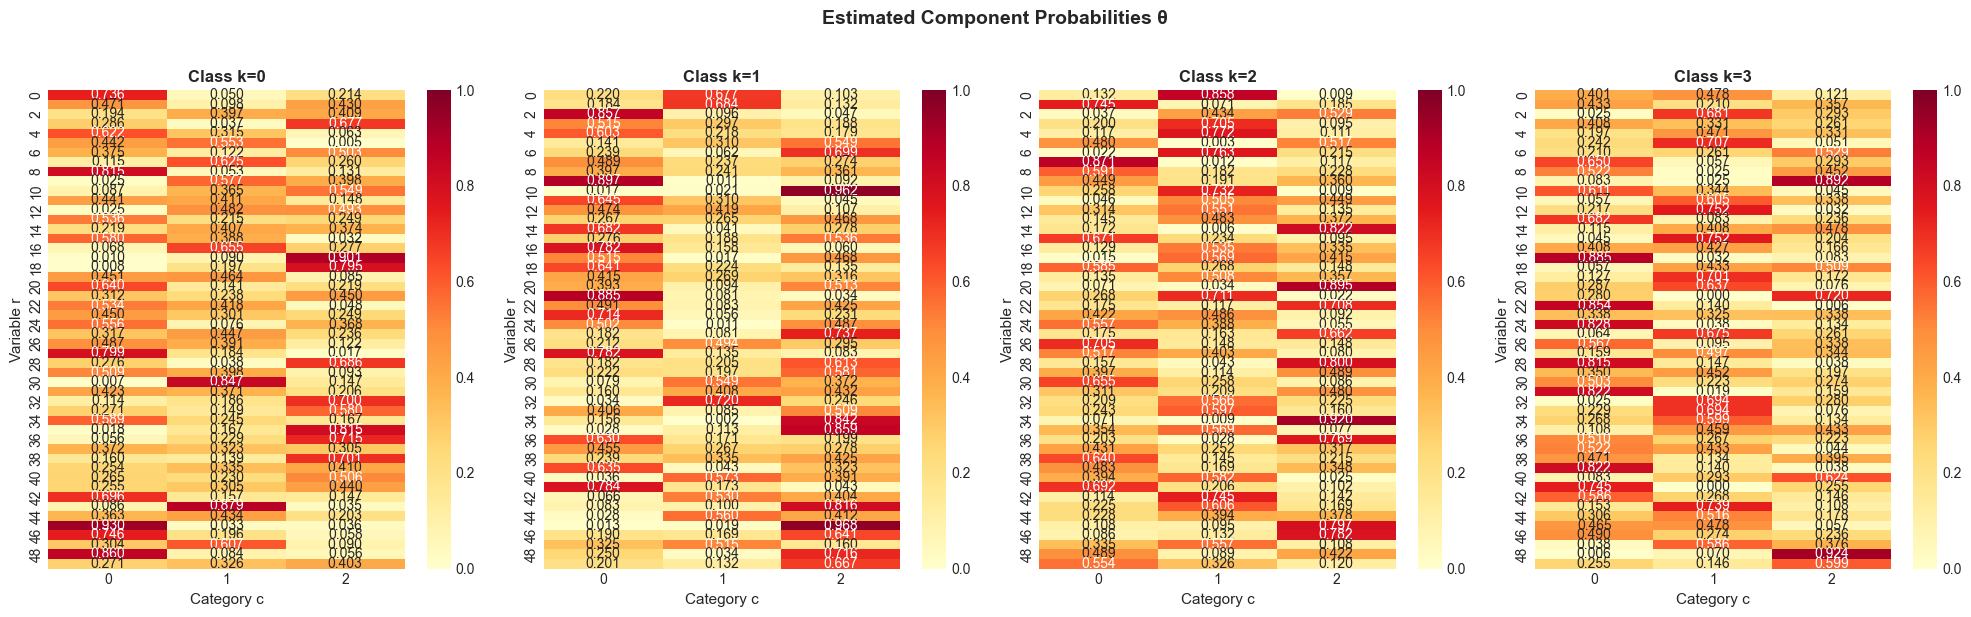

In [12]:
# ============================================================
# VISUALIZATION 4: Theta Heatmaps
# ============================================================

print("\n[VISUALIZATION] Plotting theta heatmaps...\n")

plot_theta_heatmap(true_params, title="True Component Probabilities θ")
plot_theta_heatmap(estimated_params, title="Estimated Component Probabilities θ")


[VISUALIZATION] Comparing class assignments...



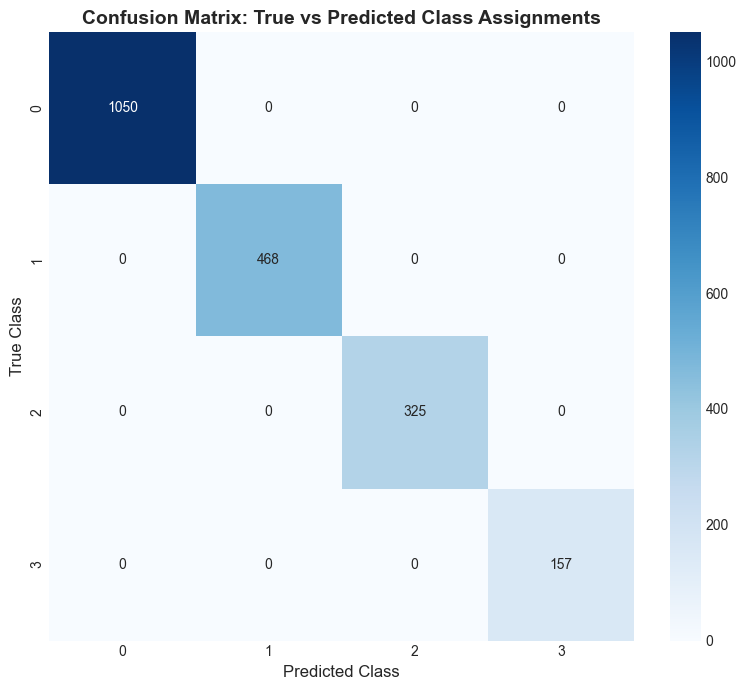


Classification Accuracy (best label matching): 1.0000
Optimal label mapping: {np.int64(0): np.int64(0), np.int64(1): np.int64(1), np.int64(2): np.int64(2), np.int64(3): np.int64(3)}


In [13]:
# ============================================================
# VISUALIZATION 5: Class Assignments
# ============================================================

print("\n[VISUALIZATION] Comparing class assignments...\n")
plot_class_assignments(H_true, H_pred)

In [14]:
# ============================================================
# QUANTITATIVE EVALUATION
# ============================================================

print("\n" + "="*60)
print("QUANTITATIVE EVALUATION")
print("="*60)

print("\nNote: Both true and estimated classes are sorted by mixture weights")
print("      (π_1 >= π_2 >= ... >= π_K) to resolve identifiability.\n")

# Mixture weights error
pi_mae = np.mean(np.abs(true_params['pi'] - estimated_params['pi']))
pi_rmse = np.sqrt(np.mean((true_params['pi'] - estimated_params['pi'])**2))

print(f"\nMixture Weights:")
print(f"  Mean Absolute Error (MAE): {pi_mae:.6f}")
print(f"  Root Mean Squared Error (RMSE): {pi_rmse:.6f}")

# Component probabilities error
theta_mae = np.mean(np.abs(true_params['theta'] - estimated_params['theta']))
theta_rmse = np.sqrt(np.mean((true_params['theta'] - estimated_params['theta'])**2))

print(f"\nComponent Probabilities:")
print(f"  Mean Absolute Error (MAE): {theta_mae:.6f}")
print(f"  Root Mean Squared Error (RMSE): {theta_rmse:.6f}")

# Convergence statistics
print(f"\nConvergence:")
print(f"  Number of iterations: {history['n_iterations']}")
print(f"  Final log-likelihood: {history['final_log_lik']:.4f}")

print("\n" + "="*60)


QUANTITATIVE EVALUATION

Note: Both true and estimated classes are sorted by mixture weights
      (π_1 >= π_2 >= ... >= π_K) to resolve identifiability.


Mixture Weights:
  Mean Absolute Error (MAE): 0.002974
  Root Mean Squared Error (RMSE): 0.003031

Component Probabilities:
  Mean Absolute Error (MAE): 0.017581
  Root Mean Squared Error (RMSE): 0.025078

Convergence:
  Number of iterations: 5
  Final log-likelihood: -84720.6294



## 6. Additional Analysis (Optional)

Explore posterior probabilities and uncertainty in class assignments.

In [15]:
# ============================================================
# Posterior Probability Analysis
# ============================================================

print("\nPosterior Probability Statistics:")
print("=" * 60)

# For each true class, show average posterior probability assigned to each class
for k_true in range(K):
    mask = (H_true == k_true)
    avg_posteriors = np.mean(gamma_pred[mask, :], axis=0)
    print(f"\nTrue Class {k_true}:")
    for k_pred in range(K):
        print(f"  Avg P(H={k_pred} | X): {avg_posteriors[k_pred]:.4f}")

# Show samples with highest uncertainty
print("\n" + "="*60)
print("Most Uncertain Predictions (entropy):")
print("="*60)

# Compute entropy of posterior probabilities
entropy = -np.sum(gamma_pred * np.log(gamma_pred + 1e-10), axis=1)
most_uncertain_idx = np.argsort(entropy)[-5:][::-1]

print(f"\n{'Sample':<10} {'True Class':<12} {'Pred Class':<12} {'Entropy':<12} Posterior Probs")
print("-" * 80)
for idx in most_uncertain_idx:
    probs_str = "  ".join([f"{p:.3f}" for p in gamma_pred[idx]])
    print(f"{idx:<10} {H_true[idx]:<12} {H_pred[idx]:<12} {entropy[idx]:<12.4f} [{probs_str}]")


Posterior Probability Statistics:

True Class 0:
  Avg P(H=0 | X): 1.0000
  Avg P(H=1 | X): 0.0000
  Avg P(H=2 | X): 0.0000
  Avg P(H=3 | X): 0.0000

True Class 1:
  Avg P(H=0 | X): 0.0000
  Avg P(H=1 | X): 1.0000
  Avg P(H=2 | X): 0.0000
  Avg P(H=3 | X): 0.0000

True Class 2:
  Avg P(H=0 | X): 0.0000
  Avg P(H=1 | X): 0.0000
  Avg P(H=2 | X): 1.0000
  Avg P(H=3 | X): 0.0000

True Class 3:
  Avg P(H=0 | X): 0.0001
  Avg P(H=1 | X): 0.0000
  Avg P(H=2 | X): 0.0000
  Avg P(H=3 | X): 0.9999

Most Uncertain Predictions (entropy):

Sample     True Class   Pred Class   Entropy      Posterior Probs
--------------------------------------------------------------------------------
239        3            3            0.1022       [0.021  0.000  0.000  0.979]
1260       3            3            0.0044       [0.001  0.000  0.000  0.999]
862        3            3            0.0038       [0.000  0.000  0.000  1.000]
1949       3            3            0.0013       [0.000  0.000  0.000  1.000]
39

## 7. Summary

The notebook implements a complete pipeline for:
1. Generating synthetic data from a latent class model
2. Estimating model parameters using the EM algorithm with numerically stable computations
3. Visualizing convergence, parameter recovery, and class assignments
4. Quantitative evaluation of estimation accuracy

Key features:
- Vectorized operations for computational efficiency
- Log-space calculations to avoid numerical underflow
- Dual stopping criteria (convergence + max iterations)
- Comprehensive visualizations
- Easy parameter control